In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
#from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
#from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.layers import Cropping2D, UpSampling2D
from keras.utils import to_categorical
#from keras.utils import np_utils

# Required for loss function
import math
from tensorflow.python.keras import losses

#from tensorflow.contrib.keras.layers import Cropping2D

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
LABEL_CLASS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Import the data

# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\dataset_lab\\train\\'
TEST_PATH = 'F:\MA\\data\\dataset_lab\\test\\'

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]

In [4]:
# Define pre-process function

from skimage.transform import resize

def pre_process(img, img_height, img_width, norm = False, rescale = False, mask = False):
    img = np.array(img)                 #list to array
    proc_img = []
    
    #proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        
    if mask:
        proc_img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    else:
        proc_img = img[:,:,np.newaxis]
        proc_img = resize(img, (img_height, img_width, 1), mode='constant', preserve_range=True)
        
    if rescale:
        proc_img /= 255
        
    #image normalization
    if norm:
        #adjusted_std = max(np.std(proc_img), 1.0/np.sqrt(proc_img.size))
        ipsilon = 0.0001
        proc_img = (proc_img-np.mean(proc_img))/np.std(proc_img)+ipsilon
        
    return proc_img

img_channel000_position009_time000000000_z002_trap_7.jpg
Original Image


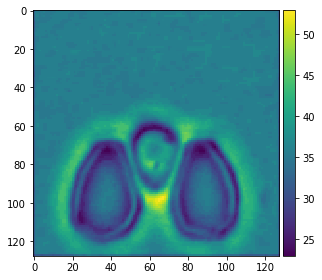

Rescale


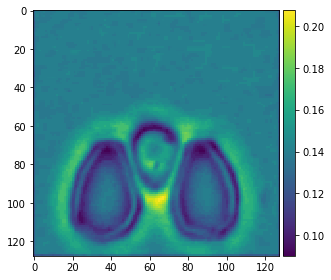

Normalization


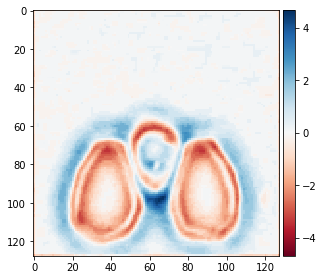

Both


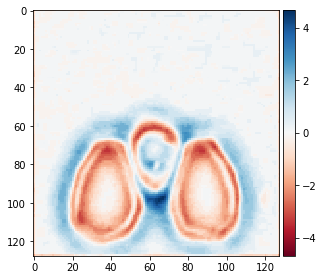

In [5]:
# Test for pre_process
id_ = train_ids[random.randint(0, len(train_ids))]
print(id_)
test_img = imread(TRAIN_PATH + 'in/' + id_)
print('Original Image')
test_img1 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT)
imshow(np.reshape(test_img1, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

print('Rescale')
test_img2 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, rescale = True)
imshow(np.reshape(test_img2, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

print('Normalization')
test_img3 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, norm = True)
imshow(np.reshape(test_img3, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

print('Both')
test_img4 = pre_process(test_img, IMG_WIDTH, IMG_HEIGHT, norm = True, rescale = True)
imshow(np.reshape(test_img4, (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

In [16]:
# Get and resize train images and masks
# X: original images, Y: masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    img = imread(TRAIN_PATH + 'in/' + id_)
    X_train[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
    mask = imread(TRAIN_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_train[n] = mask
    
    
# Get and resize test images
#sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):

    img = imread(TEST_PATH + 'in/' + id_)
    X_test[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
    mask = imread(TEST_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_test[n] = mask
    
    
print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 476/476 [00:30<00:00, 16.60it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.83it/s]


Done!


In [17]:
print(X_train.shape)
print(Y_train.shape)

(476, 128, 128, 1)
(476, 128, 128, 3)


369


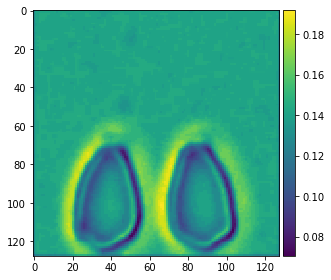

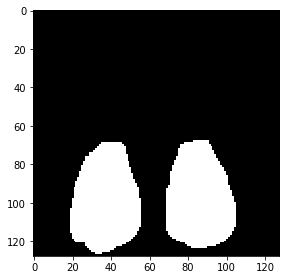

In [18]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids)-1)
print(ix)
mask_category = 1 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_train[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(Y_train[ix,:,:,mask_category])
plt.show()

33


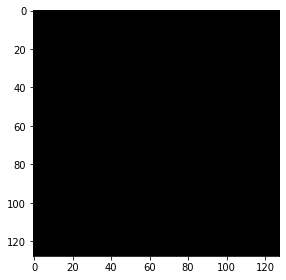

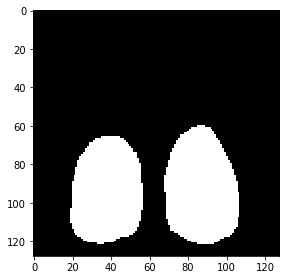

In [19]:
# Check if test data looks all right
ix = random.randint(0, len(test_ids)-1)
print(ix)
mask_category = 1 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(Y_test[ix,:,:,mask_category]) 
plt.show()

In [10]:
# Define IoU metric (NEW)  # DOESN'T WORK!!!
'''
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    e.g.: batch_size = 10 --> y_true[0,0]: the first argument of the first 
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)


        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,1]
        boxTrue_width = y_true[0,2]
        boxTrue_height = y_true[0,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,1]
        boxPred_width = y_pred[0,2]
        boxPred_height = y_pred[0,3]
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)



def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)

    return iou
'''

'\ndef calculate_iou(y_true, y_pred):\n    \n    \n    """\n    Input:\n    Keras provides the input as numpy arrays with shape (batch_size, num_columns).\n    e.g.: batch_size = 10 --> y_true[0,0]: the first argument of the first \n    \n    Arguments:\n    y_true -- first box, numpy array with format [x, y, width, height, conf_score]\n    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]\n    x any y are the coordinates of the top left corner of each box.\n    \n    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)\n    \n    """\n\n    \n    results = []\n    \n    for i in range(0,y_true.shape[0]):\n    \n        # set the types so we are sure what type we are using\n        y_true = y_true.astype(np.float32)\n        y_pred = y_pred.astype(np.float32)\n\n\n        # boxTrue\n        x_boxTrue_tleft = y_true[0,0]  # numpy index selection\n        y_boxTrue_tleft = y_true[0,1]\n        boxTrue_width = y_true[0,2]\n        boxTrue_heigh

In [20]:
def IoU(y_true,y_pred):
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = intersection / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))
    return score

def IoU_loss(y_true , y_pred):
    loss = 1 - IoU(y_true, y_pred)
    return loss

In [21]:
# Define custom metrics and loss functions
def dice_coeff(y_true,y_pred):
    smooth = 0
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true , y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss (y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
    return loss

# The same as log_loss
def mlogloss(target, pred):
    score = 0.0
    for i in range(len(pred)):
        pp = pred[i]
        for j in range(len(pp)):
            prob = pp[j]
            if prob < 1e-15:
                prob = 1e-15
            score += target[i][j] * math.log(prob)
    return -score/len(pred)

In [22]:
# Define cropping function for UNet
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2]).value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1]).value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [24]:
# Build U-Net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))

# Preprocess is conducted directly in dataset
#s = Lambda(lambda x: x / 255) (inputs)
s = inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

###################

#u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = UpSampling2D(size=(2, 2))(c5)

ch, cw = get_crop_shape(c4, u6)
crop_c4 = Cropping2D(cropping=(ch,cw))(c4)

u6 = concatenate([u6, crop_c4]) # Need to crop c4 from 64 to 56
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)


#u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = UpSampling2D(size=(2, 2))(c6)

ch, cw = get_crop_shape(c3, u7)
crop_c3 = Cropping2D(cropping=(ch,cw))(c3)

u7 = concatenate([u7, crop_c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)


#u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = UpSampling2D(size=(2, 2))(c7)

ch, cw = get_crop_shape(c2, u8)
crop_c2 = Cropping2D(cropping=(ch,cw))(c2)

u8 = concatenate([u8, crop_c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)


#u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = UpSampling2D(size=(2, 2))(c8)

ch, cw = get_crop_shape(c1, u9)
crop_c1 = Cropping2D(cropping=(ch,cw))(c1)

u9 = concatenate([u9, crop_c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(LABEL_CLASS, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss ='binary_crossentropy', metrics = [dice_loss, 'accuracy', IoU])
model.compile(optimizer='adam', loss = bce_dice_loss, metrics = [dice_loss, 'accuracy', IoU])
#model.compile(optimizer='adam', loss = IoU_loss, metrics = [IoU, dice_loss, 'accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 2320        dropout_10[0][0]                 
__________________________________________________________________________________________________
max_poolin

up_sampling2d_8 (UpSampling2D)  (None, 128, 128, 32) 0           conv2d_35[0][0]                  
__________________________________________________________________________________________________
cropping2d_8 (Cropping2D)       (None, 128, 128, 16) 0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 128, 128, 48) 0           up_sampling2d_8[0][0]            
                                                                 cropping2d_8[0][0]               
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 128, 128, 16) 6928        concatenate_8[0][0]              
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_36[0][0]                  
__________

In [25]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-lab-unet.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 428 samples, validate on 48 samples
Epoch 1/50
428/428 [==============================] - ETA: 2:23 - loss: 3.5116 - dice_loss: 0.7574 - acc: 0.1537 - IoU: 0.121 - ETA: 1:35 - loss: 2.7169 - dice_loss: 0.5326 - acc: 0.4762 - IoU: 0.233 - ETA: 1:17 - loss: 2.2960 - dice_loss: 0.4877 - acc: 0.5641 - IoU: 0.256 - ETA: 1:07 - loss: 2.0693 - dice_loss: 0.4584 - acc: 0.6183 - IoU: 0.270 - ETA: 1:00 - loss: 1.9213 - dice_loss: 0.4377 - acc: 0.6516 - IoU: 0.281 - ETA: 55s - loss: 1.7938 - dice_loss: 0.4160 - acc: 0.6783 - IoU: 0.292 - ETA: 51s - loss: 1.7257 - dice_loss: 0.4044 - acc: 0.6904 - IoU: 0.29 - ETA: 47s - loss: 1.6283 - dice_loss: 0.3869 - acc: 0.7092 - IoU: 0.30 - ETA: 44s - loss: 1.6286 - dice_loss: 0.3795 - acc: 0.7144 - IoU: 0.31 - ETA: 41s - loss: 1.5927 - dice_loss: 0.3768 - acc: 0.7200 - IoU: 0.31 - ETA: 38s - loss: 1.5552 - dice_loss: 0.3709 - acc: 0.7280 - IoU: 0.31 - ETA: 35s - loss: 1.5250 - dice_loss: 0.3650 - acc:

428/428 [==============================] - ETA: 53s - loss: 0.7658 - dice_loss: 0.1771 - acc: 0.7991 - IoU: 0.41 - ETA: 51s - loss: 0.7447 - dice_loss: 0.1758 - acc: 0.7942 - IoU: 0.41 - ETA: 49s - loss: 0.7113 - dice_loss: 0.1705 - acc: 0.7992 - IoU: 0.41 - ETA: 47s - loss: 0.6971 - dice_loss: 0.1678 - acc: 0.8047 - IoU: 0.41 - ETA: 45s - loss: 0.6988 - dice_loss: 0.1676 - acc: 0.8025 - IoU: 0.41 - ETA: 43s - loss: 0.6992 - dice_loss: 0.1668 - acc: 0.8018 - IoU: 0.41 - ETA: 41s - loss: 0.6892 - dice_loss: 0.1644 - acc: 0.8033 - IoU: 0.41 - ETA: 39s - loss: 0.6837 - dice_loss: 0.1630 - acc: 0.8047 - IoU: 0.41 - ETA: 36s - loss: 0.6817 - dice_loss: 0.1623 - acc: 0.8057 - IoU: 0.41 - ETA: 34s - loss: 0.6898 - dice_loss: 0.1632 - acc: 0.8038 - IoU: 0.41 - ETA: 32s - loss: 0.6883 - dice_loss: 0.1629 - acc: 0.8038 - IoU: 0.41 - ETA: 30s - loss: 0.6909 - dice_loss: 0.1632 - acc: 0.8032 - IoU: 0.41 - ETA: 28s - loss: 0.6982 - dice_loss: 0.1646 - acc: 0.8011 - IoU: 0.41 - ETA: 26s - loss: 0.69

428/428 [==============================] - ETA: 53s - loss: 0.6001 - dice_loss: 0.1506 - acc: 0.8199 - IoU: 0.42 - ETA: 51s - loss: 0.6228 - dice_loss: 0.1561 - acc: 0.8138 - IoU: 0.42 - ETA: 49s - loss: 0.6371 - dice_loss: 0.1579 - acc: 0.8097 - IoU: 0.42 - ETA: 47s - loss: 0.6415 - dice_loss: 0.1571 - acc: 0.8090 - IoU: 0.42 - ETA: 45s - loss: 0.6317 - dice_loss: 0.1541 - acc: 0.8135 - IoU: 0.42 - ETA: 42s - loss: 0.6390 - dice_loss: 0.1539 - acc: 0.8131 - IoU: 0.42 - ETA: 40s - loss: 0.6370 - dice_loss: 0.1522 - acc: 0.8134 - IoU: 0.42 - ETA: 38s - loss: 0.6533 - dice_loss: 0.1543 - acc: 0.8095 - IoU: 0.42 - ETA: 36s - loss: 0.6576 - dice_loss: 0.1550 - acc: 0.8087 - IoU: 0.42 - ETA: 34s - loss: 0.6677 - dice_loss: 0.1573 - acc: 0.8057 - IoU: 0.42 - ETA: 32s - loss: 0.6778 - dice_loss: 0.1599 - acc: 0.8028 - IoU: 0.42 - ETA: 30s - loss: 0.6801 - dice_loss: 0.1611 - acc: 0.8019 - IoU: 0.41 - ETA: 28s - loss: 0.6756 - dice_loss: 0.1607 - acc: 0.8028 - IoU: 0.41 - ETA: 26s - loss: 0.67

428/428 [==============================] - ETA: 53s - loss: 0.5077 - dice_loss: 0.1212 - acc: 0.8224 - IoU: 0.43 - ETA: 51s - loss: 0.4817 - dice_loss: 0.1148 - acc: 0.8284 - IoU: 0.44 - ETA: 49s - loss: 0.5208 - dice_loss: 0.1205 - acc: 0.8177 - IoU: 0.43 - ETA: 47s - loss: 0.5229 - dice_loss: 0.1194 - acc: 0.8175 - IoU: 0.44 - ETA: 45s - loss: 0.5380 - dice_loss: 0.1218 - acc: 0.8142 - IoU: 0.43 - ETA: 42s - loss: 0.5263 - dice_loss: 0.1187 - acc: 0.8178 - IoU: 0.44 - ETA: 40s - loss: 0.5246 - dice_loss: 0.1185 - acc: 0.8195 - IoU: 0.44 - ETA: 38s - loss: 0.5263 - dice_loss: 0.1185 - acc: 0.8191 - IoU: 0.44 - ETA: 36s - loss: 0.5360 - dice_loss: 0.1211 - acc: 0.8149 - IoU: 0.43 - ETA: 34s - loss: 0.5318 - dice_loss: 0.1207 - acc: 0.8164 - IoU: 0.43 - ETA: 32s - loss: 0.5349 - dice_loss: 0.1209 - acc: 0.8161 - IoU: 0.43 - ETA: 30s - loss: 0.5454 - dice_loss: 0.1222 - acc: 0.8149 - IoU: 0.43 - ETA: 28s - loss: 0.5504 - dice_loss: 0.1244 - acc: 0.8131 - IoU: 0.43 - ETA: 26s - loss: 0.54

428/428 [==============================] - ETA: 53s - loss: 0.4826 - dice_loss: 0.1002 - acc: 0.8274 - IoU: 0.44 - ETA: 51s - loss: 0.4401 - dice_loss: 0.0943 - acc: 0.8307 - IoU: 0.45 - ETA: 49s - loss: 0.4244 - dice_loss: 0.0925 - acc: 0.8344 - IoU: 0.45 - ETA: 47s - loss: 0.4462 - dice_loss: 0.0967 - acc: 0.8287 - IoU: 0.45 - ETA: 45s - loss: 0.4430 - dice_loss: 0.0962 - acc: 0.8290 - IoU: 0.45 - ETA: 43s - loss: 0.4337 - dice_loss: 0.0944 - acc: 0.8299 - IoU: 0.45 - ETA: 40s - loss: 0.4326 - dice_loss: 0.0946 - acc: 0.8306 - IoU: 0.45 - ETA: 38s - loss: 0.4376 - dice_loss: 0.0957 - acc: 0.8285 - IoU: 0.45 - ETA: 36s - loss: 0.4361 - dice_loss: 0.0952 - acc: 0.8284 - IoU: 0.45 - ETA: 34s - loss: 0.4410 - dice_loss: 0.0957 - acc: 0.8281 - IoU: 0.45 - ETA: 32s - loss: 0.4359 - dice_loss: 0.0947 - acc: 0.8292 - IoU: 0.45 - ETA: 30s - loss: 0.4325 - dice_loss: 0.0939 - acc: 0.8303 - IoU: 0.45 - ETA: 28s - loss: 0.4337 - dice_loss: 0.0940 - acc: 0.8299 - IoU: 0.45 - ETA: 26s - loss: 0.43

428/428 [==============================] - ETA: 52s - loss: 0.4900 - dice_loss: 0.0971 - acc: 0.8134 - IoU: 0.45 - ETA: 51s - loss: 0.4508 - dice_loss: 0.0919 - acc: 0.8211 - IoU: 0.45 - ETA: 49s - loss: 0.4433 - dice_loss: 0.0903 - acc: 0.8249 - IoU: 0.45 - ETA: 47s - loss: 0.4232 - dice_loss: 0.0879 - acc: 0.8308 - IoU: 0.45 - ETA: 45s - loss: 0.4203 - dice_loss: 0.0874 - acc: 0.8308 - IoU: 0.45 - ETA: 43s - loss: 0.4221 - dice_loss: 0.0876 - acc: 0.8307 - IoU: 0.45 - ETA: 41s - loss: 0.4203 - dice_loss: 0.0875 - acc: 0.8307 - IoU: 0.45 - ETA: 38s - loss: 0.4168 - dice_loss: 0.0870 - acc: 0.8311 - IoU: 0.45 - ETA: 36s - loss: 0.4151 - dice_loss: 0.0867 - acc: 0.8316 - IoU: 0.45 - ETA: 34s - loss: 0.4164 - dice_loss: 0.0871 - acc: 0.8316 - IoU: 0.45 - ETA: 32s - loss: 0.4187 - dice_loss: 0.0874 - acc: 0.8315 - IoU: 0.45 - ETA: 30s - loss: 0.4174 - dice_loss: 0.0871 - acc: 0.8323 - IoU: 0.45 - ETA: 28s - loss: 0.4161 - dice_loss: 0.0870 - acc: 0.8326 - IoU: 0.45 - ETA: 26s - loss: 0.41

428/428 [==============================] - ETA: 55s - loss: 0.4034 - dice_loss: 0.0866 - acc: 0.8310 - IoU: 0.45 - ETA: 53s - loss: 0.3910 - dice_loss: 0.0838 - acc: 0.8358 - IoU: 0.45 - ETA: 50s - loss: 0.3815 - dice_loss: 0.0819 - acc: 0.8391 - IoU: 0.45 - ETA: 48s - loss: 0.3887 - dice_loss: 0.0827 - acc: 0.8370 - IoU: 0.45 - ETA: 45s - loss: 0.3930 - dice_loss: 0.0827 - acc: 0.8361 - IoU: 0.45 - ETA: 43s - loss: 0.3964 - dice_loss: 0.0829 - acc: 0.8349 - IoU: 0.45 - ETA: 41s - loss: 0.3965 - dice_loss: 0.0829 - acc: 0.8345 - IoU: 0.45 - ETA: 39s - loss: 0.3969 - dice_loss: 0.0827 - acc: 0.8341 - IoU: 0.45 - ETA: 37s - loss: 0.3973 - dice_loss: 0.0830 - acc: 0.8331 - IoU: 0.45 - ETA: 35s - loss: 0.3981 - dice_loss: 0.0830 - acc: 0.8328 - IoU: 0.45 - ETA: 32s - loss: 0.3990 - dice_loss: 0.0831 - acc: 0.8329 - IoU: 0.45 - ETA: 30s - loss: 0.3961 - dice_loss: 0.0825 - acc: 0.8338 - IoU: 0.45 - ETA: 28s - loss: 0.3988 - dice_loss: 0.0828 - acc: 0.8337 - IoU: 0.45 - ETA: 26s - loss: 0.39

428/428 [==============================] - ETA: 54s - loss: 0.3793 - dice_loss: 0.0805 - acc: 0.8368 - IoU: 0.45 - ETA: 51s - loss: 0.3743 - dice_loss: 0.0803 - acc: 0.8369 - IoU: 0.45 - ETA: 49s - loss: 0.3780 - dice_loss: 0.0802 - acc: 0.8349 - IoU: 0.45 - ETA: 47s - loss: 0.3845 - dice_loss: 0.0808 - acc: 0.8330 - IoU: 0.45 - ETA: 45s - loss: 0.3882 - dice_loss: 0.0810 - acc: 0.8324 - IoU: 0.45 - ETA: 43s - loss: 0.3855 - dice_loss: 0.0803 - acc: 0.8340 - IoU: 0.45 - ETA: 41s - loss: 0.3902 - dice_loss: 0.0809 - acc: 0.8346 - IoU: 0.45 - ETA: 39s - loss: 0.3874 - dice_loss: 0.0804 - acc: 0.8351 - IoU: 0.45 - ETA: 37s - loss: 0.3865 - dice_loss: 0.0803 - acc: 0.8353 - IoU: 0.45 - ETA: 35s - loss: 0.3882 - dice_loss: 0.0804 - acc: 0.8350 - IoU: 0.45 - ETA: 32s - loss: 0.3879 - dice_loss: 0.0805 - acc: 0.8350 - IoU: 0.45 - ETA: 30s - loss: 0.3858 - dice_loss: 0.0802 - acc: 0.8357 - IoU: 0.45 - ETA: 28s - loss: 0.3863 - dice_loss: 0.0802 - acc: 0.8358 - IoU: 0.45 - ETA: 26s - loss: 0.38

428/428 [==============================] - ETA: 53s - loss: 0.4117 - dice_loss: 0.0835 - acc: 0.8271 - IoU: 0.45 - ETA: 51s - loss: 0.3818 - dice_loss: 0.0797 - acc: 0.8404 - IoU: 0.46 - ETA: 49s - loss: 0.3679 - dice_loss: 0.0785 - acc: 0.8438 - IoU: 0.46 - ETA: 47s - loss: 0.3809 - dice_loss: 0.0801 - acc: 0.8422 - IoU: 0.46 - ETA: 45s - loss: 0.3918 - dice_loss: 0.0817 - acc: 0.8413 - IoU: 0.45 - ETA: 43s - loss: 0.3903 - dice_loss: 0.0813 - acc: 0.8415 - IoU: 0.45 - ETA: 41s - loss: 0.3867 - dice_loss: 0.0807 - acc: 0.8417 - IoU: 0.45 - ETA: 39s - loss: 0.3904 - dice_loss: 0.0812 - acc: 0.8396 - IoU: 0.45 - ETA: 37s - loss: 0.3881 - dice_loss: 0.0809 - acc: 0.8391 - IoU: 0.45 - ETA: 35s - loss: 0.3879 - dice_loss: 0.0811 - acc: 0.8378 - IoU: 0.45 - ETA: 32s - loss: 0.3885 - dice_loss: 0.0809 - acc: 0.8370 - IoU: 0.45 - ETA: 30s - loss: 0.3886 - dice_loss: 0.0807 - acc: 0.8373 - IoU: 0.45 - ETA: 28s - loss: 0.3902 - dice_loss: 0.0809 - acc: 0.8367 - IoU: 0.45 - ETA: 26s - loss: 0.39

428/428 [==============================] - ETA: 53s - loss: 0.3845 - dice_loss: 0.0771 - acc: 0.8337 - IoU: 0.46 - ETA: 51s - loss: 0.3865 - dice_loss: 0.0780 - acc: 0.8351 - IoU: 0.46 - ETA: 49s - loss: 0.3828 - dice_loss: 0.0779 - acc: 0.8361 - IoU: 0.46 - ETA: 47s - loss: 0.3718 - dice_loss: 0.0764 - acc: 0.8395 - IoU: 0.46 - ETA: 45s - loss: 0.3679 - dice_loss: 0.0760 - acc: 0.8411 - IoU: 0.46 - ETA: 43s - loss: 0.3725 - dice_loss: 0.0764 - acc: 0.8402 - IoU: 0.46 - ETA: 41s - loss: 0.3698 - dice_loss: 0.0759 - acc: 0.8414 - IoU: 0.46 - ETA: 39s - loss: 0.3683 - dice_loss: 0.0760 - acc: 0.8417 - IoU: 0.46 - ETA: 36s - loss: 0.3702 - dice_loss: 0.0763 - acc: 0.8410 - IoU: 0.46 - ETA: 34s - loss: 0.3723 - dice_loss: 0.0766 - acc: 0.8405 - IoU: 0.46 - ETA: 32s - loss: 0.3745 - dice_loss: 0.0769 - acc: 0.8398 - IoU: 0.46 - ETA: 30s - loss: 0.3758 - dice_loss: 0.0770 - acc: 0.8394 - IoU: 0.46 - ETA: 28s - loss: 0.3765 - dice_loss: 0.0771 - acc: 0.8395 - IoU: 0.46 - ETA: 26s - loss: 0.37

428/428 [==============================] - ETA: 53s - loss: 0.3552 - dice_loss: 0.0747 - acc: 0.8420 - IoU: 0.46 - ETA: 51s - loss: 0.3728 - dice_loss: 0.0766 - acc: 0.8372 - IoU: 0.46 - ETA: 49s - loss: 0.3833 - dice_loss: 0.0773 - acc: 0.8349 - IoU: 0.46 - ETA: 47s - loss: 0.3880 - dice_loss: 0.0775 - acc: 0.8352 - IoU: 0.46 - ETA: 45s - loss: 0.3814 - dice_loss: 0.0768 - acc: 0.8370 - IoU: 0.46 - ETA: 43s - loss: 0.3768 - dice_loss: 0.0762 - acc: 0.8385 - IoU: 0.46 - ETA: 41s - loss: 0.3786 - dice_loss: 0.0767 - acc: 0.8373 - IoU: 0.46 - ETA: 38s - loss: 0.3800 - dice_loss: 0.0770 - acc: 0.8361 - IoU: 0.46 - ETA: 36s - loss: 0.3782 - dice_loss: 0.0768 - acc: 0.8358 - IoU: 0.46 - ETA: 34s - loss: 0.3796 - dice_loss: 0.0770 - acc: 0.8346 - IoU: 0.46 - ETA: 32s - loss: 0.3805 - dice_loss: 0.0772 - acc: 0.8341 - IoU: 0.46 - ETA: 30s - loss: 0.3806 - dice_loss: 0.0772 - acc: 0.8339 - IoU: 0.46 - ETA: 28s - loss: 0.3820 - dice_loss: 0.0771 - acc: 0.8332 - IoU: 0.46 - ETA: 26s - loss: 0.38

In [134]:
# evaluate the model
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)

#print(train_loss)
#print(test_loss)

In [35]:
type(history)
history.history

{'val_loss': [0.8019381761550903,
  0.7179739276568095,
  0.6447404623031616,
  0.6422608097394308,
  0.6110568443934122,
  0.469166765610377,
  0.5224011540412903,
  0.4159757395585378,
  0.5635402897993723,
  0.3077075978120168,
  0.23278738061587015,
  0.2957045336564382,
  0.22635463873545328,
  0.2371053546667099,
  0.1763507773478826,
  0.18649366994698843,
  0.19255465269088745,
  0.1814650148153305,
  0.18611091375350952,
  0.16709351042906442,
  0.16809122761090597,
  0.16835804283618927,
  0.1847617675860723,
  0.1828450212876002,
  0.1619274765253067,
  0.15639866391817728,
  0.2311179836591085,
  0.18630707263946533,
  0.1510485808054606,
  0.17650192975997925,
  0.16926157474517822,
  0.15649928152561188,
  0.18778574963410696,
  0.1612928013006846],
 'val_dice_loss': [0.2726811170578003,
  0.2176178296407064,
  0.20777634779612222,
  0.15566299359003702,
  0.14232343435287476,
  0.1314343810081482,
  0.15394105513890585,
  0.13551847139994302,
  0.117250661055247,
  0.086

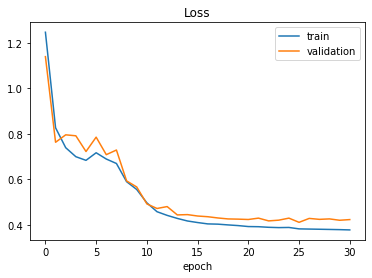

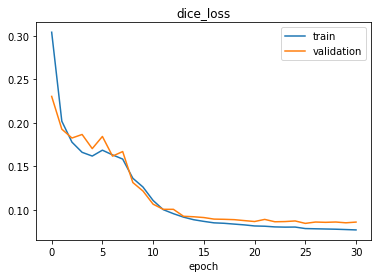

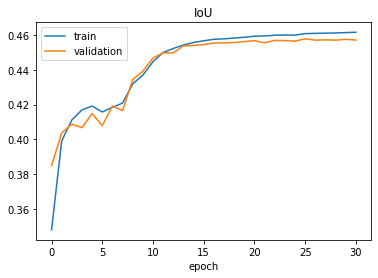

In [26]:
# plot loss during training
plt.title('Loss')
#train_loss = history.history['loss']
#test_loss = history.history['val_loss']
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.legend()
plt.show()
#plt.savefig('result_loss.png')

# plot dice_loss during training
plt.figure()
plt.title('dice_loss')
plt.plot(history.history['dice_loss'], label='train')
plt.plot(history.history['val_dice_loss'], label='validation')
plt.xlabel('epoch')
plt.legend()
plt.show()
#plt.savefig('result_dice.png')

# plot IoU during training
plt.figure()
plt.title('IoU')
plt.plot(history.history['IoU'], label='train')
plt.plot(history.history['val_IoU'], label='validation')
plt.xlabel('epoch')
plt.legend()
plt.show()
#plt.savefig('result_iou.png')

#plt.savefig('result.png')